In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras import backend as K

2025-01-03 08:25:56.577609: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-03 08:25:57.817077: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-03 08:25:57.817104: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-03 08:25:57.826673: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-03 08:25:58.240584: I tensorflow/core/platform/cpu_feature_g

In [2]:
import sys
sys.path.append('scripts/')
from simulation_based_likelihood import *
from synthetic_data import *
from simba_gradient_univariate import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [4]:
# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 12  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 15  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 15  # Font size of title

In [5]:
import pylab 
import scipy.stats as stats

from scipy import stats

chi2 = stats.chi2
gaussian = stats.norm

In [6]:
covariates_n = 2

M = 2

T = 100

parallel_simulations = 500

tf.random.set_seed((T))
np.random.seed((T))

In [7]:
seed_filter_N = tfp.random.split_seed( T, n=3, salt='filter_N')

N_list       = [100, 1000, 2000]
epsilon_list = [0.00001, 0.001, 0.1] 
q_list       = [[0.2, 0.1], [0.6, 0.4], [0.9, 0.9]]

loglike_simba_list = []
loglike_condsimba_list = []
filter_performance_simba_list = []
filter_performance_condsimba_list = []

for n in range(3):

	seed_filter_eps = tfp.random.split_seed( seed_filter_N[n], n=3, salt='filter_eps')
	print("N="+str(N_list[n]))

	for e in range(3):

		seed_filter_q = tfp.random.split_seed( seed_filter_eps[e], n=3, salt='filter_q')
		print("eps="+str(epsilon_list[e]))

		for qi in range(3):
			
			seed_filter = tfp.random.split_seed( seed_filter_q[qi], n=101, salt='filter_q')

			N = N_list[n]
			W_tensor = tf.stack((tf.ones(N), tfp.distributions.Normal(loc = 0.0, scale = 1.0).sample(N)), axis = -1)

			input_0      = tuple([W_tensor])
			input_kernel = tuple([W_tensor])

			model = compartmental_model(N, input_0, input_kernel, SIS_initial, SIS_transition)

			initial_infection_rate = 0.01
			beta_0      = tf.convert_to_tensor( [-np.log((1/initial_infection_rate)-1), +0], dtype = tf.float32 )
			beta_lambda = tf.convert_to_tensor( [-1,           +2],      dtype = tf.float32 )  
			beta_gamma  = tf.convert_to_tensor( [-1,           -1],      dtype = tf.float32 )  
			epsilon     = tf.convert_to_tensor( [epsilon_list[e]],                  dtype = tf.float32 )  

			parameters_0 = tuple([beta_0])

			q_0      = tf.convert_to_tensor([0.0, 0.0], dtype = tf.float32)   
			q_static = tf.convert_to_tensor(q_list[qi], dtype = tf.float32)

			q_0_expanded      = tf.expand_dims(tf.expand_dims(q_0, axis = 0), axis = 0)
			q_static_expanded = tf.expand_dims(tf.expand_dims(q_static, axis = 0), axis = 0)

			parameters_emission = tuple([q_static])

			parameters_kernel = beta_lambda, beta_gamma, epsilon
			q_dynamic = tf.concat((q_0_expanded*tf.ones((1, N, M)), q_static_expanded*tf.ones((T, N, M))), axis =0)

			x, y = sim(model, parameters_0, parameters_kernel, q_dynamic, T, seed_filter[0])

			simulation_likelihood_model = simulation_likelihood(parallel_simulations, N, input_0, input_kernel, 
									SIS_initial_grad, SIS_transition_grad, SIS_emission_grad)

			loglike_simba = []
			loglike_condsimba = []

			filter_performance_simba = []
			filter_performance_condsimba = []

			for i in range(100):
				seed_filter_split = tfp.random.split_seed( seed_filter[i], n=2, salt='filter_split')

				out_simba     = run_simba_full(       simulation_likelihood_model, parameters_0, parameters_kernel, parameters_emission, y, seed_filter_split[0])
				out_condsimba = run_simba_full_filter(simulation_likelihood_model, parameters_0, parameters_kernel, parameters_emission, y, seed_filter_split[1])

				filter_simba     = tf.reduce_mean(out_simba[0], axis = 1)
				filter_condsimba = tf.reduce_mean(out_condsimba[0], axis = 1)

				loglike_simba.append(tf.reduce_sum(out_simba[1]))
				loglike_condsimba.append(tf.reduce_sum(out_condsimba[1]))

				filter_performance_simba.append(tf.reduce_mean(tf.reduce_mean(tf.reduce_sum(x[1:,:,:]*filter_simba, axis = -1), axis =-1)))
				filter_performance_condsimba.append(tf.reduce_mean(tf.reduce_mean(tf.reduce_sum(x[1:,:,:]*filter_condsimba, axis = -1), axis =-1)))

			loglike_simba = np.stack(loglike_simba)
			loglike_condsimba = np.stack(loglike_condsimba)

			filter_performance_simba =np.stack(filter_performance_simba)
			filter_performance_condsimba =np.stack(filter_performance_condsimba)

			loglike_simba_list.append(loglike_simba)
			loglike_condsimba_list.append(loglike_condsimba)
			filter_performance_simba_list.append(filter_performance_simba)
			filter_performance_condsimba_list.append(filter_performance_condsimba)

2025-01-03 08:26:03.763606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-03 08:26:04.719456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-03 08:26:04.719617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-03 08:26:04.725920: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-03 08:26:04.725981: I tensorflow/compile

N=100
eps=1e-05


2025-01-03 08:26:07.522311: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x424676a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-03 08:26:07.522353: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-01-03 08:26:07.535990: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-03 08:26:07.780343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-03 08:26:08.768761: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


eps=0.001
eps=0.1
N=1000
eps=1e-05
eps=0.001
eps=0.1
N=2000
eps=1e-05
eps=0.001
eps=0.1


We have some nans so rerun the for the corresponding scenario

In [9]:
loglike_simba_list[1]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [10]:
N_list       = [100, 1000, 2000]
epsilon_list = [0.00001, 0.001, 0.1] 
q_list       = [[0.2, 0.1], [0.6, 0.4], [0.9, 0.9]]

n = 0	
seed_filter_eps = tfp.random.split_seed( seed_filter_N[n]+1, n=3, salt='filter_eps')

e = 0
seed_filter_q = tfp.random.split_seed( seed_filter_eps[e], n=3, salt='filter_q')

qi =1
seed_filter = tfp.random.split_seed( seed_filter_q[qi], n=101, salt='filter_q')

N = N_list[n]
W_tensor = tf.stack((tf.ones(N), tfp.distributions.Normal(loc = 0.0, scale = 1.0).sample(N)), axis = -1)

input_0      = tuple([W_tensor])
input_kernel = tuple([W_tensor])

model = compartmental_model(N, input_0, input_kernel, SIS_initial, SIS_transition)

initial_infection_rate = 0.01
beta_0      = tf.convert_to_tensor( [-np.log((1/initial_infection_rate)-1), +0], dtype = tf.float32 )
beta_lambda = tf.convert_to_tensor( [-1,           +2],      dtype = tf.float32 )  
beta_gamma  = tf.convert_to_tensor( [-1,           -1],      dtype = tf.float32 )  
epsilon     = tf.convert_to_tensor( [epsilon_list[e]],                  dtype = tf.float32 )  

parameters_0 = tuple([beta_0])

q_0      = tf.convert_to_tensor([0.0, 0.0], dtype = tf.float32)   
q_static = tf.convert_to_tensor(q_list[qi], dtype = tf.float32)

q_0_expanded      = tf.expand_dims(tf.expand_dims(q_0, axis = 0), axis = 0)
q_static_expanded = tf.expand_dims(tf.expand_dims(q_static, axis = 0), axis = 0)

parameters_emission = tuple([q_static])

parameters_kernel = beta_lambda, beta_gamma, epsilon
q_dynamic = tf.concat((q_0_expanded*tf.ones((1, N, M)), q_static_expanded*tf.ones((T, N, M))), axis =0)

x, y = sim(model, parameters_0, parameters_kernel, q_dynamic, T, seed_filter[0])

simulation_likelihood_model = simulation_likelihood(parallel_simulations, N, input_0, input_kernel, 
						SIS_initial_grad, SIS_transition_grad, SIS_emission_grad)

loglike_simba = []
loglike_condsimba = []

filter_performance_simba = []
filter_performance_condsimba = []

for i in range(100):
	seed_filter_split = tfp.random.split_seed( seed_filter[i], n=2, salt='filter_split')

	out_simba     = run_simba_full(       simulation_likelihood_model, parameters_0, parameters_kernel, parameters_emission, y, seed_filter_split[0])
	out_condsimba = run_simba_full_filter(simulation_likelihood_model, parameters_0, parameters_kernel, parameters_emission, y, seed_filter_split[1])

	filter_simba     = tf.reduce_mean(out_simba[0], axis = 1)
	filter_condsimba = tf.reduce_mean(out_condsimba[0], axis = 1)

	loglike_simba.append(tf.reduce_sum(out_simba[1]))
	loglike_condsimba.append(tf.reduce_sum(out_condsimba[1]))

	filter_performance_simba.append(tf.reduce_mean(tf.reduce_mean(tf.reduce_sum(x[1:,:,:]*filter_simba, axis = -1), axis =-1)))
	filter_performance_condsimba.append(tf.reduce_mean(tf.reduce_mean(tf.reduce_sum(x[1:,:,:]*filter_condsimba, axis = -1), axis =-1)))

loglike_simba = np.stack(loglike_simba)
loglike_condsimba = np.stack(loglike_condsimba)

filter_performance_simba =np.stack(filter_performance_simba)
filter_performance_condsimba =np.stack(filter_performance_condsimba)

In [11]:
loglike_simba_list[1] = loglike_simba
loglike_condsimba_list[1] = loglike_condsimba

filter_performance_simba_list[1] = filter_performance_simba
filter_performance_condsimba_list[1] = filter_performance_condsimba

In [19]:
from tabulate import tabulate

N_list       = [100, 1000, 2000]
epsilon_list = ["low", "medium", "high"] 
q_list       = ["low", "medium", "high"] 

table = []

header = ["Simba-CL", r"$N$", r"$\epsilon$", r"$q$", "log-likelihood", "filtering performance"]
# table.append(header)

index = 0
for n in range(3):

	for e in range(3):

		for qi in range(3):

			loglike_mean_str =     str(np.round(np.nanmean(loglike_simba_list[index].astype(float)), 2))
			loglike_std_str  = "("+str(np.round(np.nanstd(loglike_simba_list[index].astype(float)), 4))+")"
			
			filter_mean_str =     str(np.round(np.nanmean(filter_performance_simba_list[index].astype(float)), 2))
			filter_std_str  = "("+str(np.round(np.nanstd(filter_performance_simba_list[index].astype(float)), 7))+")"
			
			table_row_uncond = ["Unconditional", str(N_list[n]), str(epsilon_list[e]), str(q_list[qi]), loglike_mean_str+loglike_std_str, filter_mean_str+filter_std_str]

			table.append(table_row_uncond)

			loglike_mean_str =     str(np.round(np.nanmean(loglike_condsimba_list[index].astype(float)), 2))
			loglike_std_str  = "("+str(np.round(np.nanstd(loglike_condsimba_list[index].astype(float)), 4))+")"
			
			filter_mean_str =     str(np.round(np.nanmean(filter_performance_condsimba_list[index].astype(float)), 2))
			filter_std_str  = "("+str(np.round(np.nanstd(filter_performance_condsimba_list[index].astype(float)), 7))+")"
			
			table_row_cond = ["Conditional", str(N_list[n]), str(epsilon_list[e]), str(q_list[qi]), loglike_mean_str+loglike_std_str, filter_mean_str+filter_std_str]
			table.append(table_row_cond)
			
			index = index + 1

# Creating and displaying the table
print(tabulate(table, header, tablefmt="latex_raw"))

\begin{tabular}{lrllll}
\hline
 Simba-CL      &   $N$ & $\epsilon$   & $q$    & log-likelihood     & filtering performance   \\
\hline
 Unconditional &   100 & low          & low    & -5131.96(2.6794)   & 0.84(0.0005827)         \\
 Conditional   &   100 & low          & low    & -5100.07(0.0432)   & 0.83(6.01e-05)          \\
 Unconditional &   100 & low          & medium & -6785.45(3.4968)   & 0.97(0.0018434)         \\
 Conditional   &   100 & low          & medium & -6738.07(0.0425)   & 1.0(6.9e-06)            \\
 Unconditional &   100 & low          & high   & -3340.12(3.4506)   & 1.0(0.00021)            \\
 Conditional   &   100 & low          & high   & -3295.73(0.0156)   & 1.0(3e-07)              \\
 Unconditional &   100 & medium       & low    & -5179.42(1.8061)   & 0.85(0.0010506)         \\
 Conditional   &   100 & medium       & low    & -5143.67(0.2772)   & 0.87(0.0002244)         \\
 Unconditional &   100 & medium       & medium & -8313.9(2.3432)    & 0.91(0.0001687)    

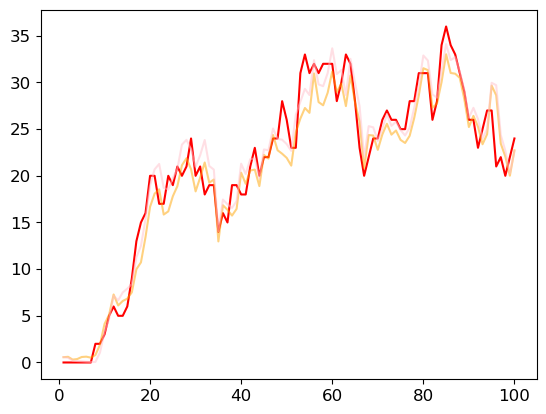

In [18]:
filter_simba     = tf.reduce_mean(out[0], axis = 1)
filter_condsimba = tf.reduce_mean(out_filter[0], axis = 1)

time = np.linspace(1, T, T)
plt.plot(time, tf.reduce_sum(x, axis =1)[1:, 1], color = "red")
plt.plot(time, tf.reduce_sum(filter_simba, axis = 1)[:,1], color = "orange", alpha = 0.5)
plt.plot(time, tf.reduce_sum(filter_condsimba, axis = 1)[:,1], color = "pink", alpha = 0.5)